
# Assignment 1 - Event-driven simulation of a two-dimensional gas
## Numerical Physics 2023
## Introduction

For this project, a Julia kernel in a Jupyter Notebook is used. The Julia kernel is a programming language that is similar to Python, but has more built in utilities for computational physics. The Jupyter Notebook is a web-based interactive computational environment for creating Jupyter notebook documents. The notebook documents contain both computer code (e.g. Julia) and rich text elements (paragraph, equations, figures, links, etc...). The notebook documents can be converted to different formats, including HTML, LaTeX, PDF, and Markdown. The Jupyter Notebook is an open-source project, and is available at https://jupyter.org/.



## Includes

In [1]:
# using Pkg
# Pkg.add("ProgressBars")
using Base.Threads,
BenchmarkTools,
DataStructures, # For PriorityQueue
Random,
Statistics,
StatsBase,
Plots,
ProgressBars

display("Number of threads: $(nthreads())")

"Number of threads: 8"

In [2]:
a = zeros(10)
Threads.@threads for i = 1:10
    a[i] = Threads.threadid()
end
a

10-element Vector{Float64}:
 1.0
 1.0
 2.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0

## Definitions

### Particle & collision structs

In [3]:
# Types of collisions
@enum CollisionType::Int64 uninit = 0 vwall = 1 hwall = 2 particle = 3

# Define particle struct
mutable struct Particle
    ## Particle properties
    # x, y: position
    # vx, vy: velocity
    # m: mass
    # ξ: elastic collision coefficient
    # r: radius
    # nc: realtime number of collision
    # def: true if particle is defined

    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    m::Float64
    ξ::Float64
    r::Float64
    nc::Int64

    ## Next collision properties
    coll_type::CollisionType
    other_particle_idx::Int64
    # Collision count at calculation, if coll_nc != nc when resolving collision, discard collision and calculate new
    coll_nc::Int64 

    # Time until next collision
    Δt::Float64
    # Time since last collision
    tc::Float64
    

    ## Constructor

    Particle(x::Float64, y::Float64, vx::Float64, vy::Float64, m::Float64, ξ::Float64, r::Float64, tc::Float64) =
        new(x, y, vx, vy, m, ξ, r, 0, 
        uninit::CollisionType, 0, 0, 0.0, 0.0)
    Particle(x::Float64, y::Float64, vx::Float64, vy::Float64, m::Float64, ξ::Float64, r::Float64) =
        Particle(x, y, vx, vy, m, ξ, r, 0.0)

end

ξ(p::Particle) = p.tc <= 0.0 ? p.ξ : 1.0

# Define function to update velocities of particles after particle collision
function update_velocities!(p_i::Particle, p_j::Particle)::Nothing
    dx = p_j.x - p_i.x
    dy = p_j.y - p_i.y
    dvx = p_j.vx - p_i.vx
    dvy = p_j.vy - p_i.vy
    dvdr = dx*dvx + dy*dvy
    ## distance between centers at collision point squared
    ## is equal to their added radii squared
    R2 = dx^2 + dy^2

    p_i.vx += (1+ξ(p_i))*(p_j.m / (p_i.m + p_j.m)) * dvdr * dx / R2
    p_i.vy += (1+ξ(p_i))*(p_j.m / (p_i.m + p_j.m)) * dvdr * dy / R2
    p_j.vx -= (1+ξ(p_j))*(p_i.m / (p_i.m + p_j.m)) * dvdr * dx / R2
    p_j.vy -= (1+ξ(p_j))*(p_i.m / (p_i.m + p_j.m)) * dvdr * dy / R2

    return nothing
end

# Define function to update velocity of a particle
# after collision with a vertical wall
function update_velocity_vertical_wall!(p::Particle)::Nothing
    p.vx *= -ξ(p)
    p.vy *= ξ(p)
    return nothing
end

# Define function to update velocity of a particle
# after collision with a horizontal wall
function update_velocity_horizontal_wall!(p::Particle)::Nothing
    p.vx *= ξ(p)
    p.vy *= -ξ(p)
    
    return nothing
end

# Define function to update positions of particles
function update_positions!(particles::Vector{Particle}, Δt::Float64)::Nothing
    for p in particles
        p.x += p.vx * Δt
        p.y += p.vy * Δt
    end
    return nothing
end

update_positions! (generic function with 1 method)

### Time calculations

In [4]:
# Define function to calculate time until collision with vertical wall
function time_until_collision_vertical_wall(p::Particle, L::Float64)::Float64
    if p.vx > 0 ## Right wall
        return (L - p.r - p.x) / p.vx

    elseif p.vx < 0 ## Left wall
        return (p.r - p.x) / p.vx

    else ## It is standing still in x, probably? :^)
        return Inf
    end
end

# Define function to calculate time until collision with horizontal wall
function time_until_collision_horizontal_wall(p::Particle, L::Float64)::Float64
    if p.vy > 0 ## Top wall
        return (L - p.r - p.y) / p.vy

    elseif p.vy < 0 ## Bottom wall
        return (p.r - p.y) / p.vy

    else ## It is standing still in y, plausibly? 8-)
        return Inf
    end
end

# Define function to calculate time until collision between two particles
function time_until_collision(p1::Particle, p2::Particle)::Float64
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    dvx = p2.vx - p1.vx
    dvy = p2.vy - p1.vy

    dvdr = dx*dvx + dy*dvy
    dvdv = dvx^2 + dvy^2
    drdr = dx^2 + dy^2
    R2 = (p1.r + p2.r)^2

    # Discriminant in collision
    d = dvdr^2 - dvdv * (drdr - R2)

    if d <= 0 || dvdr >= 0
        return Inf
    else
        return -(dvdr + sqrt(d)) / dvdv
    end
end

time_until_collision (generic function with 1 method)

### Simulation loop function

In [5]:
# Calculate time until next collision for each particle
function calc_collision!(i, particles::Vector{Particle})::Nothing
    p_i = particles[i]
    p_i.Δt = Inf
    p_i.coll_type = uninit::CollisionType
    p_i.other_particle_idx = 0
    
    @inbounds @threads for j in filter(x -> x != i, eachindex(particles))
        p_j = particles[j]
        Δt = time_until_collision(p_i, p_j)
        if Δt < p_i.Δt
            p_i.Δt = Δt
            p_i.coll_type = particle::CollisionType
            p_i.other_particle_idx = j
        end
    end

    return nothing
end

# Define function to calculate time until next wall collision
function calc_wall_collision!(i, particles::Vector{Particle}, L::Float64)::Nothing
    p_i = particles[i]
    
    Δt = time_until_collision_vertical_wall(p_i, L)
    if Δt < p_i.Δt
        p_i.Δt = Δt
        p_i.coll_type = vwall::CollisionType
        p_i.other_particle_idx = 0
    end

    Δt = time_until_collision_horizontal_wall(p_i, L)
    if Δt < p_i.Δt
        p_i.Δt = Δt
        p_i.coll_type = hwall::CollisionType
        p_i.other_particle_idx = 0
    end
    
    return nothing
end

function update!(particles::Vector{Particle}, pq::PriorityQueue{Int64, Float64}, coll_t::Float64 = 0.0)::Nothing
    i, Δt = peek(pq)
    p_i = particles[i]

    j = p_i.other_particle_idx

    # Update positions of all particles
    update_positions!(particles, Δt)
    # Update priority queue with new times
    @inbounds @threads for i in eachindex(particles)
        particles[i].Δt -= Δt
        particles[i].tc -= Δt
        pq[i] = particles[i].Δt
    end

    ## Handle the collision and velocity update
    if p_i.coll_nc == p_i.nc
        if p_i.coll_type == vwall::CollisionType
            update_velocity_vertical_wall!(p_i)
            p_i.nc += 1
            
        elseif p_i.coll_type == hwall::CollisionType
            update_velocity_horizontal_wall!(p_i)
            p_i.nc += 1

        elseif p_i.coll_type == particle::CollisionType

            p_j = particles[j]

            if p_j.coll_nc == p_j.nc
                # Discard if the other particle has collided with something before this
                ## Complete the collision for both particles
                update_velocities!(p_i, p_j)
                p_j.nc += 1
                p_i.nc += 1
            end

            # Calc collision for the other particle
            calc_collision!(j, particles)
            calc_wall_collision!(j, particles, L)
            p_j.coll_nc = deepcopy(p_j.nc) # collision count at the time. If mismatch when resolving collision, it is ignored
            p_j.tc = deepcopy(coll_t)
            # Add the other particle to the priority queue
            pq[j] = p_j.Δt

        end

        p_i.tc = deepcopy(coll_t)
        
    end

    # Calculate time until next collision for this particle
    calc_collision!(i, particles)
    calc_wall_collision!(i, particles, L)
    p_i.coll_nc = deepcopy(p_i.nc) ## collision count at the time. If mismatch when resolving collision, it is ignored
    pq[i] = p_i.Δt

    


    return nothing
end

# Define simulation loop
function simulate!(particles::Vector{Particle}, L::Float64, N::Int64, coll_t::Float64)::Nothing
    # Initialize priority queue with particle indexes and time until collision
    pq = PriorityQueue{Int64, Float64}()

    # Calculate time until next collision for each particle
    for i in 1:length(particles)
        calc_collision!(i, particles)
        calc_wall_collision!(i, particles, L)
        pq[i] = particles[i].Δt
    end

    # Run simulation
    for i in 1:N
        # Get particle with next collision
        update!(particles, pq)
    end

    for p in particles
        @assert p.x > 0.0 && p.x < L
        @assert p.y > 0.0 && p.y < L
    end
    return nothing
end 


simulate! (generic function with 1 method)

In [6]:
# Define function to plot particles
function plot_particles(particles::Vector{Particle}, L::Float64, color::String, label::String)
    # Plot particles
    scatter([particles[i].x for i in 1:length(particles)],
        [particles[i].y for i in 1:length(particles)],
        color = color, label = label)

    # Plot vertical walls
    plot!([0, 0], [0, L], color = "black", label = nothing)
    plot!([L, L], [0, L], color = "black", label = nothing)

    # Plot horizontal walls
    plot!([0, L], [0, 0], color = "black", label = nothing)
    plot!([0, L], [L, L], color = "black", label = nothing)
end

function plot_particles!(particles::Vector{Particle}, L::Float64, color::String, label::String)
    # Plot particles
    scatter!([particles[i].x for i in 1:length(particles)],
        [particles[i].y for i in 1:length(particles)],
        color = color, label = label)

end

function plot_line!(p0, p1)
    plot!([p0.x, p1.x], [p0.y, p1.y], color = "black", label = nothing)
end

plot_line! (generic function with 1 method)

In [7]:
function energy(particles)
    return sum([0.5 * p.m * (p.vx^2 + p.vy^2) for p in particles])
end

energy (generic function with 1 method)

## Test cases

#### Test case 1

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 2^-4


# test case 1a
N = 1
particles = [Particle(0.5, 0.5, 0.5, 0.0, m, ξ, r)]
p0 = deepcopy(particles)

Nt = 1 ## Just one collision please
display("Test 1a: Direct wall collision")

# Plot initial conditions
plot_particles(particles, L, "blue", "Initial")

# Simulate collisions
simulate!(particles, L, Nt)

display(particles)

display(eps(Float64))

plot_particles!(particles, L, "red", "Wall hit")

plot!([p0[1].x, particles[1].x], [p0[1].y, particles[1].y], color = "black",
ylims = (0, L), xlims = (0, L), label = nothing)

p0 = deepcopy(particles)

# test case 1b
display("Test 1b: Angle preservation")
particles[1].vy = -0.5
display("Angle before is $(atan(particles[1].vy / particles[1].vx))")

simulate!(particles, L, Nt)

display("Angle after is $(atan(particles[1].vy / particles[1].vx))")

plot_particles!(particles, L, "green", "Angle")

plot!([p0[1].x, particles[1].x], [p0[1].y, particles[1].y], color = "black",
ylims = (0, L), xlims = (0, L), label = nothing)

p0 = deepcopy(particles)

# test case 1c
display("Test 1c: Complete stop.")
display(particles)
particles[1].ξ = 0.0
simulate!(particles, L, Nt)
display(particles)

plot!([p0[1].x, particles[1].x], [p0[1].y, particles[1].y], color = "black",
ylims = (0, L), xlims = (0, L), label = nothing)

plot_particles!(particles, L, "pink", "Complete stop")

#### Test case 2

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 2^-7
display("Radius = $r")



# Test case 2
N = 2
particles = [Particle(0.7, 0.5, -0.5, 0.0, m, ξ, r), 
Particle(0.3, 0.5, 0.5, 0.0, m, ξ, r)]

p0 = deepcopy(particles)
Nt = 1 ## Just one collision please

display(particles)
# Plot initial conditions
plot_particles(particles, L, "blue", "Initial")
# Simulate collisions
simulate!(particles, L, Nt)

display(particles)
display("Energy before is $(energy(p0))")
display("Energy after is $(energy(particles))")

plot_particles!(particles, L, "red", "1st")
plot_line!(p0[1], particles[1])
plot_line!(p0[2], particles[2])


In [ ]:
# Test case 2b, two particles hit at 45 degrees
display("Test 2b: Two particles hit at 45 degrees")
# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 1e-3
display("Radius = $r")
N = 2
θ = 45
Nt = 1
particles = [Particle(0.7, 0.3, -0.5 * cosd(θ), 0.5 * sind(θ), m, ξ, r),
Particle(0.3, 0.3, 0.5 * cosd(θ), 0.5 * sind(θ), m, ξ, r)]

plot_particles(particles, L, "green", "Init Pos angle test")

p0 = deepcopy(particles)
display(p0)
simulate!(particles, L, Nt)
display(particles)
p1 = deepcopy(particles)
display("Angle before is $(atan(p0[1].vy / p0[1].vx))")
display("Angle after is $(atan(particles[1].vy / particles[1].vx))")

display("Energy before is $(energy(p0))")

simulate!(particles, L, Nt)


display("Energy after is $(energy(particles))")
display("Energy loss is $(energy(p0) - energy(particles))")
plot_line!(p0[1], p1[1])
plot_line!(p0[2], p1[2])
plot_line!(p1[1], particles[1])
plot_line!(p1[2], particles[2])
plot_particles!(particles, L, "red", "end")

In [ ]:
# Test case 2b, two particles hit at 45 degrees
display("Test 2c: Two particles hit at 45 degrees, sticky")
ξ = 0.0
N = 2
θ = 45.0
particles = [Particle(0.7, 0.3, -0.5 * cosd(θ), 0.5 * sind(θ), m, ξ, r),
Particle(0.3, 0.3, 0.5 * cosd(θ), 0.5 * sind(θ), m, ξ, r)]

plot_particles(particles, L, "green", "Init Pos sticky angle test")

p0 = deepcopy(particles)
display(p0)
simulate!(particles, L, Nt)
display(particles)
p1 = deepcopy(particles)
display("Angle before is $(atan(p0[1].vy / p0[1].vx))")
display("Angle after is $(atan(particles[1].vy / particles[1].vx))")

simulate!(particles, L, Nt)

plot_line!(p0[1], p1[1])
plot_line!(p0[2], p1[2])
plot_line!(p1[1], particles[1])
plot_line!(p1[2], particles[2])
plot_particles!(particles, L, "red", "end")

#### Test case 3: Energy conservation

In [ ]:


# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 1e-5

# test case 3 many particles, conserve energy
display("Test 3: Many particles, conserve energy")
N = 1000
grid_sampler = hcat(0.01:2r:0.99, 0.01:2r:0.99)
xys = sample(grid_sampler, (N,2), replace = false)
θs = rand(0:360, N)
v0 = 0.1

particles = [Particle(xys[i,1], xys[i,2], v0*cosd(θs[i]), v0*sind(θs[i]), m, ξ, r) for i in 1:N]
Nt = 1000
plot_particles(particles, L, "blue", "1")
display("Initial energy is $(energy(particles))")
p0 = deepcopy(particles)


simulate!(particles, L, Nt)

for p in particles
    if p.x < 0 || p.x > L || p.y < 0 || p.y > L
        display("Particle $(p) escaped!")
    end
end

display("Energy 2 is $(energy(particles))")
display("Energy loss is $(energy(p0) - energy(particles))")
display(particles[1])


# Count number of collisions
nc = 0
for p in particles
    nc += p.nc
end
display("Number of collisions is $nc")

plot_particles!(particles, L, "red", "2")



#### Energy loss over time

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 1e-4

# test case 3 many particles, conserve energy
display("Test 3: Many particles, conserve energy")
N = 1000
grid_sampler = hcat(0.01:2r:0.99, 0.01:2r:0.99)
xys = sample(grid_sampler, (N,2), replace = false)
θs = rand(0:360, N)
v0 = 0.1

particles = [Particle(xys[i,1], xys[i,2], v0*cosd(θs[i]), v0*sind(θs[i]), m, ξ, r) for i in 1:N]
Nt = 1000

e0 = energy(particles)
energy_hist = []

nc = 0 # number of collisions
pnc_percent = 0.0 # percent of particles that have collided with other particles
Ne = 100
for i in 1:Ne
    simulate!(particles, L, 1)
    push!(energy_hist, e0 - energy(particles))

    # Count number of collisions
    for p in particles
        nc += p.nc
        pnc_percent += p.coll_type == particle::CollisionType ? 1 : 0
    end
end

pnc_percent /= N*Ne
display("Approx percent of particle type collisions $(pnc_percent*100)%)")


xticks = (trunc.(Int, range(0, Ne, length = 5)), trunc.(Int, range(0, Ne*Nt, length=5)))
display(typeof(xticks))

plot(energy_hist, label="Ensemble energy", xlabel="Iterations", ylabel="Energy",
    title="Energy conservation test\n #collisions = $nc",
    xticks = xticks,
    ylims=(-2*maximum(energy_hist), 2*maximum(energy_hist)))

### Realtime scalability test

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 0.001

# test case 3 many particles, conserve energy
display("Realtime benchmark test: Check reasonable simulation scaling.")
N = 1000
grid_sampler = [(x,y) for x in 0.01:2r:0.99, y in 0.01:2r:0.99]
xys = sample(grid_sampler, (N,2), replace = false)
θs = rand(0:360, N)
v0 = 0.1

particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), m, ξ, r) for i in 1:N]
Nt = 1000

display("N = $N, Nt = $Nt")
display(@btime simulate!($particles, $L, $Nt))
display("N_coll: $(sum([p.nc for p in particles]))")

display("N = $N, Nt = $(Nt*10)")
display(@btime simulate!($particles, $L, $Nt*10))
display("N_coll: $(sum([p.nc for p in particles]))")

N = 10000
grid_sampler = [(x,y) for x in 0.01:2r:0.99, y in 0.01:2r:0.99]
xys = sample(grid_sampler, (N), replace = false)
θs = rand(0:360, N)
v0 = 0.1
particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), m, ξ, r) for i in 1:N]

display("N = $N, Nt = $Nt")
display(@btime simulate!($particles, $L, $Nt))
display("N_coll: $(sum([p.nc for p in particles]))")

display("N = $N, Nt = $(Nt*10)")
display(@btime simulate!($particles, $L, $Nt*10))
display("N_coll: $(sum([p.nc for p in particles]))")




### Code type instability warning

In [ ]:
@code_warntype simulate!(particles, L, Nt)

## Problem solutions

### Problem 1

#### Initial distribution

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
r = 0.001

display("Problem 1: Init Velocity distribution")
N = 10000
grid_sampler = [(x,y) for x in 0.01:2r:0.99, y in 0.01:2r:0.99]
xys = sample(grid_sampler, (N,2), replace = false)
θs = rand(0:360, N)
v0 = 0.1

particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), m, ξ, r) for i in 1:N]
p0 = deepcopy(particles)
vel_distribution = [sqrt(p.vx^2 + p.vy^2) for p in particles]

histogram(vel_distribution, ylims=(0,1000), label=nothing,
xlabel="Velocity", ylabel="Count", title="Velocity distribution initial",
xlims=(0.05,0.15), bins = 50)

#### Loop

In [ ]:
Nt = Int64(1e5)
simulate!(particles, L, Nt)

In [ ]:
# display("Number of collisions is $nc")
display("Energy difference is $(energy(p0) - energy(particles))")
v0_rms = sqrt(mean([(p.vx^2 + p.vy^2) for p in p0]))
v_rms = sqrt(mean([(p.vx^2 + p.vy^2) for p in particles]))
display("Init rms velocity is $v0_avg")
display("Final rms velocity is $v_avg")


In [ ]:
display(nc)
# plot velocity distribution
vel_distribution = [sqrt(p.vx^2 + p.vy^2) for p in particles]
histogram(vel_distribution, label="Particle histogram",
xlabel="Velocity [m/s]", ylabel="Probability [%]", title="Velocity distribution final",
bins = 200, xlims=(0.00,0.2), normed=true)

## plot Maxwell-Boltzmann distribution
# boltzmann constant
k = 1.38e-23
# boltzmann distribution
pdf_BE(v,v_avg) = 2*v/v_avg^2 * exp(-v^2/v_avg^2)
vs = 0.0:0.001:0.2

plot!(vs, pdf_BE.(vs,v0), label="Boltzmann distribution",
    linewidth=2, color=:red, linestyle=:dash)

### Problem 2

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ0 = 1.0
m0 = 1.0
m1 = 4 * m0
r = 0.001

display("Problem 1: Init Velocity distribution")
N = 10000
grid_sampler = [(x,y) for x in 0.01:2r:0.99, y in 0.01:2r:0.99]
xys = sample(grid_sampler, (N,2), replace = false)
θs = rand(0:360, N)
v0 = 0.1

# Half of particles use m0, other half use m1
particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), i <= N/2 ? m0 : m1, ξ0, r) for i in 1:N]
p0 = deepcopy(particles)

histogram([sqrt(p.vx^2 + p.vy^2) for p in particles], ylims=(0,N), label=nothing,
xlabel="Velocity", ylabel="Count", title="Velocity distribution initial",
xlims=(0.05,0.15), bins = 50)


In [ ]:
# Simulation loop
Nt = Int64(1e4)
simulate!(particles, L, Nt)

In [ ]:
display("Energy difference is $(energy(p0) - energy(particles))")

Nhalf = trunc(Int64, N/2)
v00_avg = mean([sqrt(p.vx^2 + p.vy^2) for p in p0[1:Nhalf]])
v01_avg = mean([sqrt(p.vx^2 + p.vy^2) for p in p0[Nhalf+1:N]])

v0_avg = mean([sqrt(p.vx^2 + p.vy^2) for p in particles[1:Nhalf]])
v1_avg = mean([sqrt(p.vx^2 + p.vy^2) for p in particles[Nhalf+1:N]])

display("Init avg m0 velocity is $v00_avg")
display("Init avg m1 velocity is $v01_avg")
display("Final avg m0 velocity is $v0_avg")
display("Final avg m1 velocity is $v1_avg")



In [ ]:
# plot velocity distribution
vel0_distribution = [sqrt(p.vx^2 + p.vy^2) for p in particles[1:Nhalf]]
vel1_distribution = [sqrt(p.vx^2 + p.vy^2) for p in particles[Nhalf+1:N]]
histogram(vel0_distribution, label="Particle histogram, m = 1",
xlabel="Velocity [m/s]", ylabel="Probability [%]", title="Velocity distribution final",
bins = 200, xlims=(0.0,0.4), normed=true, alpha=0.7)

histogram!(vel1_distribution, label="Particle histogram, m = 4",
bins = 100, xlims=(0.0,0.4), normed=true, alpha=0.7)

## plot Maxwell-Boltzmann distribution
# boltzmann constant
k = 1.38e-23
# boltzmann distribution
pdf_BE(v,v_avg) = 2*v/v_avg^2 * exp(-v^2/v_avg^2)
vs = 0.0:0.001:0.4

plot!(vs, pdf_BE.(vs,v0_avg), label="Boltzmann distribution, m=1",
    linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7)
plot!(vs, pdf_BE.(vs,v1_avg), label="Boltzmann distribution, m=4",
    linewidth=2, color=:red, linestyle=:dash, alpha=0.7)

### Problem 3

In [ ]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m0 = 1.0
m1 = 4 * m0
r = 0.001

display("Problem 1: Init Velocity distribution")
N = 10000
grid_sampler = [(x,y) for x in 0.01:2r:0.99, y in 0.01:2r:0.99]
xys = sample(grid_sampler, (N), replace = false)
θs = rand(0:360, N)
v0 = 0.1

# Half of particles use m0, other half use m1
particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), i <= N/2 ? m0 : m1, ξ, r) for i in 1:N]
p0 = deepcopy(particles)

In [ ]:
# Iterate over simulations of collisions and calculate total kinetic energy for
# each step, kinetic energy for first half and second half of particles
Nt = Int64(1e3)
Nhalf = trunc(Int64, N/2)
E0 = zeros(Nt)
E00 = zeros(Nt)
E01 = zeros(Nt)

for i in 1:Nt
    simulate!(particles, L, 100)
    E0[i] = energy(particles)
    E00[i] = energy(particles[1:Nhalf])
    E01[i] = energy(particles[Nhalf+1:N])
end


In [ ]:
# Averages
E0 ./= N
E00 ./= Nhalf
E01 ./= Nhalf

In [ ]:
# Plot kinetic energy
plot(E0, label="Total", linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7,
title = "Average kinetic energy,\n Elasticity ξ=1.0", xlabel="Iter (×100)", ylabel="Energy")
plot!(E00, label="m=1", linewidth=2, color=:red, linestyle=:dash, alpha=0.7)
plot!(E01, label="m=4", linewidth=2, color=:green, linestyle=:solid, alpha=0.7)

In [ ]:
## Zoom in, enhance
xticks = (0:200:400, [600, 1000])
# Plot kinetic energy
plot(E0[600:1000], label="Total", linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7,
title = "Average kinetic energy,\n Elasticity ξ=1.0\nZoomed", xlabel="Iter (×100)", ylabel="Energy", xticks=xticks)
plot!(E00[600:1000], label="m=1", linewidth=2, color=:red, linestyle=:dash, alpha=0.7)
plot!(E01[600:1000], label="m=4", linewidth=2, color=:green, linestyle=:solid, alpha=0.7)

In [ ]:
# Repeat for ξ = 0.9
ξ = 0.9

# Half of particles use m0, other half use m1

particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), i <= N/2 ? m0 : m1, ξ, r) for i in 1:N]
p0 = deepcopy(particles)

display("innit?")

In [ ]:
# Iterate over simulations of collisions and calculate total kinetic energy for
# each step, kinetic energy for first half and second half of particles
Nt = Int64(1e3)
Nhalf = trunc(Int64, N/2)
E1 = zeros(Nt)
E10 = zeros(Nt)
E11 = zeros(Nt)

for i in 1:Nt
    simulate!(particles, L, 100)
    E1[i] = energy(particles)
    E10[i] = energy(particles[1:Nhalf])
    E11[i] = energy(particles[Nhalf+1:N])
end

In [ ]:

# Averages
E1 ./= N
E10 ./= Nhalf
E11 ./= Nhalf

In [ ]:


# Plot kinetic energy
plot(E1, label="Total", linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7,
title = "Kinetic energy,\n Elasticity ξ=0.9", xlabel="Iter x 100", ylabel="Energy")
plot!(E10, label="m=1", linewidth=2, color=:red, linestyle=:dash, alpha=0.7)
plot!(E11, label="m=4", linewidth=2, color=:green, linestyle=:solid, alpha=0.7)


In [ ]:
## Zoom in, enhance
xticks = (0:200:200, [800, 1000])
# Plot kinetic energy
plot(E1[800:1000], label="Total", linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7,
title = "Average kinetic energy,\n Elasticity ξ=0.9\nZoomed", xlabel="Iter (×100)", ylabel="Energy", xticks=xticks)
plot!(E10[800:1000], label="m=1", linewidth=2, color=:red, linestyle=:dash, alpha=0.7)
plot!(E11[800:1000], label="m=4", linewidth=2, color=:green, linestyle=:solid, alpha=0.7)

In [ ]:
# Repeat for ξ = 0.8
ξ = 0.8

# Half of particles use m0, other half use m1

particles = [Particle(xys[i][1], xys[i][2], v0*cosd(θs[i]), v0*sind(θs[i]), i <= N/2 ? m0 : m1, ξ, r) for i in 1:N]
p0 = deepcopy(particles)

display("innit?")

In [ ]:
# Iterate over simulations of collisions and calculate total kinetic energy for
# each step, kinetic energy for first half and second half of particles
Nt = Int64(1e3)
Nhalf = trunc(Int64, N/2)
E2 = zeros(Nt)
E20 = zeros(Nt)
E21 = zeros(Nt)

for i in 1:Nt
    simulate!(particles, L, 100)
    E2[i] = energy(particles)
    E20[i] = energy(particles[1:Nhalf])
    E21[i] = energy(particles[Nhalf+1:N])
end

In [ ]:

# Averages
E2 ./= N
E20 ./= Nhalf
E21 ./= Nhalf

In [ ]:


# Plot kinetic energy
plot(E2, label="Total", linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7,
title = "Kinetic energy,\n Elasticity ξ=0.8", xlabel="Iter (×100)", ylabel="Energy")
plot!(E20, label="m=1", linewidth=2, color=:red, linestyle=:dash, alpha=0.7)
plot!(E21, label="m=4", linewidth=2, color=:green, linestyle=:solid, alpha=0.7)


In [ ]:
## Zoom in, enhance
xticks = (0:200:200, [800, 1000])
# Plot kinetic energy
plot(E2[800:1000], label="Total", linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7,
title = "Kinetic energy,\n Elasticity ξ=0.8\nZoomed", xlabel="Iter (×100)", ylabel="Energy", xticks=xticks)
plot!(E20[800:1000], label="m=1", linewidth=2, color=:red, linestyle=:dash, alpha=0.7)
plot!(E21[800:1000], label="m=4", linewidth=2, color=:green, linestyle=:solid, alpha=0.7)

### Problem 4

In [31]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions
function init_crater_particles(R_factor = 5)::Vector{Particle}
    # Define initial conditions
    L = 1.0
    ξ0 = 0.5
    m = 1.0
    M = 25 * m
    N = 3333
    # Suggested packing fraction is approximately 0.5+~
    # Radius should then be
    # Area of half the box A_b = 0.5*L^2
    # Area of a particle A_p = π*r^2
    # Packing fraction = A_p/A_b = N*π*r^2/(0.5*L^2) = π*r^2/(0.5*L^2)
    # =>    r = sqrt(0.5*L^2/(N*π)) * pf
    pf = 0.5
    r = sqrt(0.5*L^2/(N*π) * pf)
    R = R_factor*r
    yrange = range(1.5r, L/2, ceil(Int, sqrt(0.5N)))
    xrange = range(1.5r, L-1.5r, ceil(Int, sqrt(2N)))
    v0 = 5.0

    # Make a grid sampler for random position tuples
    grid_sampler = [(x + 0.5r*rand(), y + 0.5r*rand()) for x in xrange, y in yrange]

    xys = sample(grid_sampler, N, replace = false)

    # Half of particles use m0, other half use m1
    particles = [Particle(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0) for i in 1:N+1]
    particles[1] = Particle(0.5, 0.75, 0.0, -v0, M, ξ0, R)
    particles[2:end] = [Particle(xys[i][1], xys[i][2], 0.0, 0.0, m, ξ0, r) for i in 1:N]
    return particles
end

init_crater_particles (generic function with 2 methods)

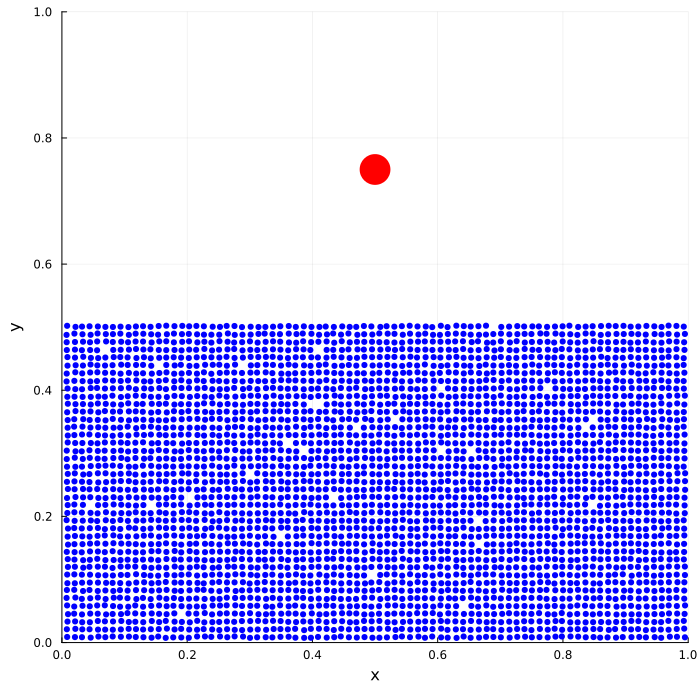

In [32]:
particles = init_crater_particles()
p1 = particles[1]
p2 = particles[2]
plotsize = 700
scatter([particles[1].x], [particles[1].y], markersize=p1.r * plotsize, color="red", legend=nothing,
ylims=(0,1), xlims=(0,1), xlabel="x", ylabel="y", markerstrokewidth=0, size=(plotsize,plotsize))
scatter!([particles[i].x for i in 2:length(particles)], [particles[i].y for i in 2:length(particles)], markersize=p2.r * plotsize, color="blue", label=nothing, markerstrokewidth=0)

In [33]:
rfs = 1:1:10
particle_ensemble = [init_crater_particles(rf) for rf in rfs]
idxs = 1:length(rfs)
crater_radius_measure = zeros(length(velocities))
crater_depth_measure = zeros(length(velocities))
L = 1.0

coll_t = 1e-8
Nt = 100
@threads for i in idxs
    p = particle_ensemble[i]
    p0 = deepcopy(p)
    e0 = energy(p)
    e = energy(p)
    iter = 0
    try 
        while e > 0.10*e0 ## Keep iterating until 10% of initial energy is left
            try
                simulate!(p, L, Nt, coll_t)
            catch ex
                if typeof(ex) == InterruptException
                    rethrow(ex)
                else
                    new = ErrorException(ex.msg * " at iter $i")
                    throw(new)
                end
            end
            e = energy(p)
            iter += 1
        end
    catch ex
        display(ex.msg * " at velocity $i")
        continue # If sim at one velocity fails, continue with next
    end
    display("Velocity $i converged after $iter simulations of size $Nt each.")
    ## Measure impact by y coordinate of large particle
    crater_depth_measure[i] = p[1].y - p[1].r
    ## Measure impact radius by summing up all x-displacement
    crater_radius_measure[i] = sum(abs(p[i].x - p0[i].x) for i in 2:length(p))
end

"Velocity 1 converged after 317 simulations of size 100 each."

"Velocity 7 converged after 454 simulations of size 100 each."

"Velocity 5 converged after 393 simulations of size 100 each."

"Velocity 3 converged after 414 simulations of size 100 each."

"Velocity 6 converged after 390 simulations of size 100 each."

"Velocity 9 converged after 488 simulations of size 100 each."

"Velocity 10 converged after 484 simulations of size 100 each."

"Velocity 8 converged after 600 simulations of size 100 each."

"Velocity 2 converged after 302 simulations of size 100 each."

"Velocity 4 converged after 435 simulations of size 100 each."

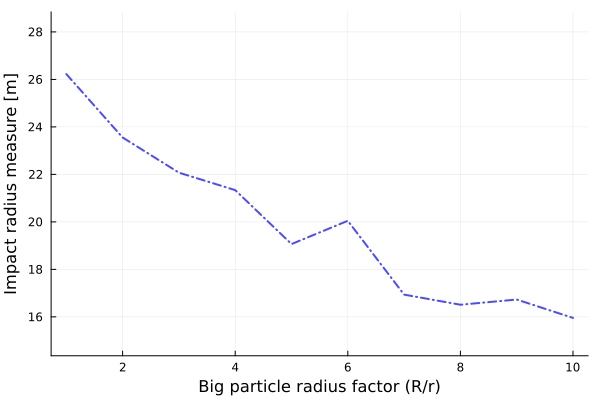

In [38]:
plot(rfs, crater_radius_measure[1:10], label=nothing, linewidth=2, color=:blue, linestyle=:dashdot, alpha=0.7, xlabel="Big particle radius factor (R/r)", ylabel="Impact radius measure [m]",
ylims = (0.9minimum(crater_radius_measure[1:10]), 1.1maximum(crater_radius_measure[1:10])))

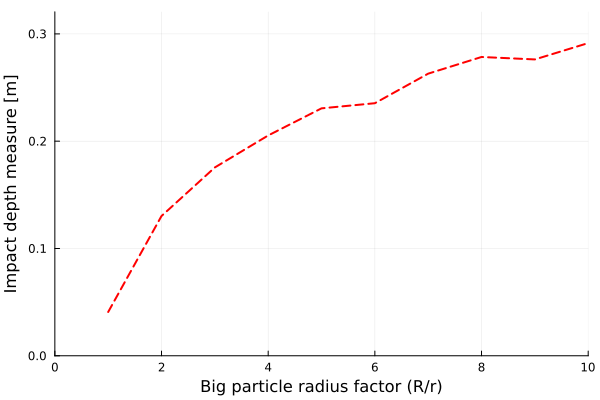

In [37]:
plot(rfs, crater_depth_measure[1:10], label=nothing, linewidth=2, color=:red, linestyle=:dash,
xlabel="Big particle radius factor (R/r)", ylabel="Impact depth measure [m]",
ylims = (0.9minimum(crater_depth_measure), 1.1maximum(crater_depth_measure)),
xlims = (0.0, 10))

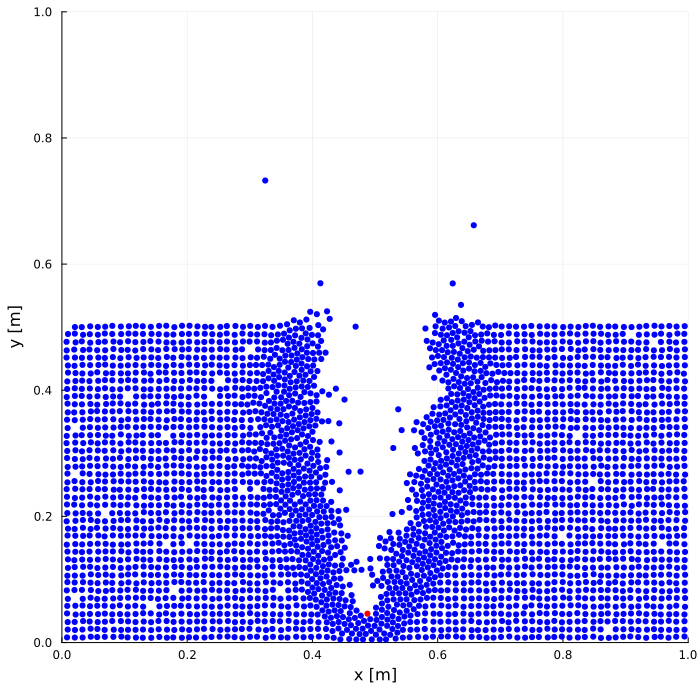

In [39]:
particles = particle_ensemble[1]
p1 = particles[1]
p2 = particles[2]
plotsize = 700
scatter([particles[1].x], [particles[1].y], markersize=p1.r * plotsize, color="red", legend=nothing,
ylims=(0,1), xlims=(0,1), xlabel="x [m]", ylabel="y [m]", markerstrokewidth=0, size=(plotsize,plotsize))
scatter!([particles[i].x for i in 2:length(particles)], [particles[i].y for i in 2:length(particles)], markersize=p2.r * plotsize, color="blue", label=nothing, markerstrokewidth=0)

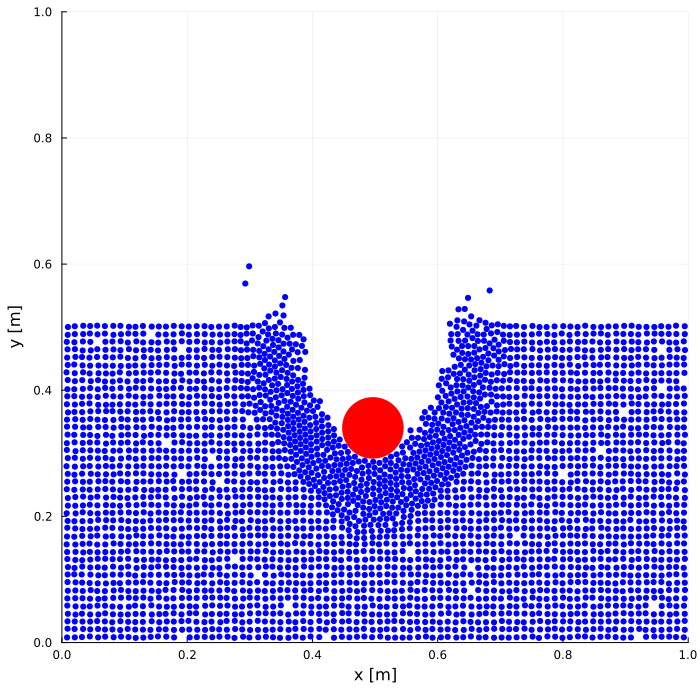

In [40]:
particles = particle_ensemble[end]
p1 = particles[1]
p2 = particles[2]
plotsize = 700
scatter([particles[1].x], [particles[1].y], markersize=p1.r * plotsize, color="red", legend=nothing,
ylims=(0,1), xlims=(0,1), xlabel="x [m]", ylabel="y [m]", markerstrokewidth=0, size=(plotsize,plotsize))
scatter!([particles[i].x for i in 2:length(particles)], [particles[i].y for i in 2:length(particles)], markersize=p2.r * plotsize, color="blue", label=nothing, markerstrokewidth=0)

#### Parameter scan of different masses